# Moving $x_s$ from stage to stage

In [28]:
import numpy as np
from dataLoad import dataset_from_name
from optimizer.linear3 import Optimal
import itertools
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook

Auxillary functions

In [29]:
def learn(X, y):
    N, n = X.shape
    num_feat = n - 1

    def get_counts(X):
        N, n = X.shape
        p = np.zeros(tuple([2] * n))
        for i in range(N):
            p[tuple(X[i, :])] += 1
        return p

    Xy = np.hstack((X, y))
    p = get_counts(X) / N
    py = get_counts(X[Xy[:, -1] == 1]) / N / (p + 10e-9)
    return p, py

def get_fairness(optimizer, alpha2, fairness_def):
    gfs, lfs, volfs = [], [], []
    for alpha1 in np.linspace(alpha2, 1, 20):
        gf, lf, volf = optimizer.minimize_violation([alpha1, alpha2],  fairness_def=fairness_def, num_stage=2)
        gfs.append(gf)
        lfs.append(lf)
        volfs.append(volf)
    return np.array(gfs) / np.array(lfs) , volfs

## Simulation procedure

Choose dataset_name:
* adult
* compas
* german

and fairness_def $\in$ {dp, eo}

In [31]:
from optimizer.greedy2 import Greedy
from optimizer.linear3 import Optimal
import pickle


dataset_name = "adult"
fairness_def = "eo"

optimizer = Optimal()
alpha2 = 0.3

data = dataset_from_name(dataset_name).astype(int)
features = list(data)[:-1]
label = list(data)[-1]

try:
    polfs = pickle.load(open( "./data/polf-fair-{}-{}.pickle".format(dataset_name, fairness_def), "rb" ) )
    volfs = pickle.load(open( "./data/volf-fair-{}-{}.pickle".format(dataset_name, fairness_def), "rb" ) )
    keys = pickle.load(open( "./data/key-fair-{}-{}.pickle".format(dataset_name, fairness_def), "rb" ) )
except:
    polfs = {}
    volfs = {}
    keys = []
for Xs in features:   
    if Xs not in polfs:
        polfs[Xs] = []
        volfs[Xs] = []
    perm = itertools.permutations(features, 4)
    print (Xs)
    for feature_comb in tqdm_notebook(perm):
        if Xs not in feature_comb:
            X1 = list(np.sort(feature_comb[:2]))
            X2 = list(np.sort(feature_comb[2:]))
            key = tuple([Xs] + list(X1) + list(X2))
            if key not in keys:
                p, py = learn(data[[Xs] + X1 + X2].values, data[[label]].values)
                ps = {1: np.zeros((2,2,2,2,2,2,2)), 2: np.zeros((2,2,2,2,2,2,2)), 3: np.zeros((2,2,2,2,2))}
                pys = {1: np.zeros((2,2,2,2,2,2,2)), 2: np.zeros((2,2,2,2,2,2,2)), 3: np.zeros((2,2,2,2,2))}
                for xs, x1, x2, x3, x4 in itertools.product([0, 1], repeat=5): 
                    ps[1][xs, xs, x1, x2, x3, x4, x4] = p[xs,x1,x2,x3,x4]
                    pys[1][xs, xs, x1, x2, x3, x4, x4] = py[xs,x1,x2,x3,x4]

                    ps[2][xs, x1, x1, x2, x3, x4, xs] = p[xs,x1,x2,x3,x4]
                    pys[2][xs, x1, x1, x2, x3, x4, xs] = py[xs,x1,x2,x3,x4]

                    ps[3][xs,x1,x2,x3,x4] = p[xs,x1,x2,x3,x4]
                    pys[3][xs,x1,x2,x3,x4] = py[xs,x1,x2,x3,x4]
                polf_temp, volf_temp = [], []
                for stage in [1,2,3]:
                    optimizer.p = ps[stage]
                    optimizer.py = pys[stage]
                    if stage == 3:
                        optimizer.num_feat = 4
                    else:
                        optimizer.num_feat = 6
                    polf, volf = get_fairness(optimizer, alpha2, fairness_def)
                    polf_temp.append(polf)
                    volf_temp.append(volf)

                polfs[Xs].append(polf_temp)
                volfs[Xs].append(volf_temp)

                keys.append(key)
            pickle.dump(keys, open("./data/key-fair-{}-{}.pickle".format(dataset_name, fairness_def), "wb"))
            pickle.dump(polfs, open("./data/polf-fair-{}-{}.pickle".format(dataset_name, fairness_def), "wb"))
            pickle.dump(volfs, open("./data/volf-fair-{}-{}.pickle".format(dataset_name, fairness_def), "wb"))

sex


/usr/local/lib/python3.7/site-packages/pulp/pulp.py:1349: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")



age



native_country



hours_per_week



education



relationship


In [11]:
opt = Optimal()
data = dataset_from_name("adult").astype(int)
opt.learn(data[["sex", "age", "age", "education", "sex","relationship", "native_country"]].values, data[["income"]].values)
alpha2 = 0.3
alpha1s = np.linspace(alpha2, 1, 20)
u = {"uf": [], "gf": [], "lf": []}
for alpha1 in alpha1s:
    u["uf"].append(opt.fit([alpha1, alpha2]))
    u["gf"].append(opt.fit([alpha1, alpha2], fairness_type="gf", fairness_def="dp"))
    u["lf"].append(opt.fit([alpha1, alpha2], fairness_type="lf", fairness_def="dp"))

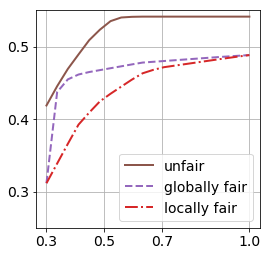

In [12]:
fig = plt.figure(figsize=(4,4))
names = ["UF", "GF", "LF"]
colors=["#8c564b", "#9467bd", "#d62728"]
linestyles=["-", "--", "-."]
# plt.subplot(121)
plt.ylim(0.25, 0.55)
for i, v in enumerate(u):
    plt.plot(alpha1s, u[v], linestyles[i], color=colors[i], linewidth=2,)
plt.xticks([0.3, 0.5, 0.7, 1], fontsize=14)
plt.yticks([0.3, 0.4, 0.5], fontsize=14)
plt.grid()
names = ["unfair", "globally fair", "locally fair"]
plt.legend(names, fontsize=14)
plt.savefig("../ijcai19/fig/u_gap-2.pdf", bbox_inches='tight')

In [13]:
print (alpha1s, np.array(u["gf"]) / np.array(u["lf"]))

[0.3        0.33684211 0.37368421 0.41052632 0.44736842 0.48421053
 0.52105263 0.55789474 0.59473684 0.63157895 0.66842105 0.70526316
 0.74210526 0.77894737 0.81578947 0.85263158 0.88947368 0.92631579
 0.96315789 1.        ] [1.         1.29107346 1.24306953 1.17626023 1.13691366 1.10161125
 1.08092736 1.06305163 1.04614656 1.03197679 1.02379753 1.01806853
 1.01573877 1.0134299  1.01114164 1.00887371 1.00659518 1.00431347
 1.00210041 1.        ]


## $PoLF_1$ vs $PoLF_2$ for Adult dataset

600 0.84
600 0.935
600 0.945


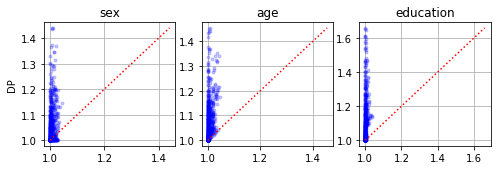

In [15]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp"]:
    data = pickle.load(open("./data/polf-fair-adult-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "age", "education"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        polf = [[], [], []]
        for i in range(len(data[Xs])):
            for j in range(3):
                polf[j] += list(data[Xs][i][j])
        print (len(polf[0]), np.mean(np.array(polf[0]) < np.array(polf[1])))
        plt.plot(polf[0], polf[1], ".", color="blue", alpha=0.2)
        plt.plot([1, np.max(polf[1])], [1, np.max(polf[1])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-adult.pdf", bbox_inches="tight")

# $VoLF_1$ vs $VoLF_2$ for Adult dataset

0.19 0.09 0.72
0.275 0.09833333333333333 0.6266666666666667
0.31333333333333335 0.19833333333333333 0.48833333333333334


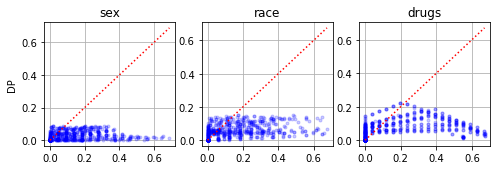

In [22]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp"]:
    data = pickle.load(open("./data/volf-fair-compas-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "race", "drugs"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        volf = [[], [], []]
        for i in range(len(data[Xs])):
            for j in range(3):
                volf[j] += list(data[Xs][i][j])
        plt.plot(volf[0], volf[1], ".", color="blue", alpha=0.2)
        print (np.mean(np.array(volf[0]) < np.array(volf[1])), np.mean(np.array(volf[0]) == np.array(volf[1])), np.mean(np.array(volf[0]) > np.array(volf[1])))
        plt.plot([0, np.max(volf[0])], [0, np.max(volf[0])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-adult.pdf", bbox_inches="tight")

0.15 0.10833333333333334 0.7416666666666667
0.08166666666666667 0.09833333333333333 0.82
0.058333333333333334 0.15333333333333332 0.7883333333333333


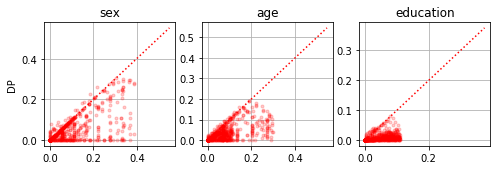

In [18]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp"]:
    data = pickle.load(open("./data/volf-fair-adult-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "age", "education"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        volf = [[], [], []]
        for i in range(len(data[Xs])):
            for j in range(3):
                volf[j] += list(data[Xs][i][j])
        plt.plot(volf[1], volf[2], ".", color="red", alpha=0.2)
        print (np.mean(np.array(volf[1]) < np.array(volf[2])), np.mean(np.array(volf[1]) == np.array(volf[2])), np.mean(np.array(volf[1]) > np.array(volf[2])))
        plt.plot([0, np.max(volf[0])], [0, np.max(volf[0])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-adult.pdf", bbox_inches="tight")

## $PoLF_1$ vs $PoLF_2$ for COMPAS dataset

600 0.955
600 0.95
600 0.955
600 0.9316666666666666
600 0.935
600 0.935


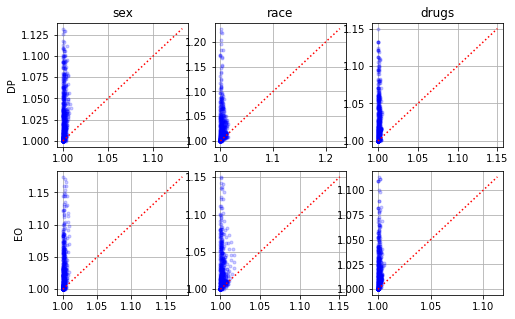

In [28]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp", "eo"]:
    data = pickle.load(open("./data/result-fair-compas-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "race", "drugs"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        polf = [[], [], []]
        for i in range(len(data[Xs])):
            for j in range(3):
                polf[j] += list(data[Xs][i][j])
        print (len(polf[0]), np.mean(np.array(polf[0]) < np.array(polf[1])))

        plt.plot(polf[0], polf[1], ".", color="blue", alpha=0.2)
        plt.plot([1, np.max(polf[1])], [1, np.max(polf[1])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-adult.pdf", bbox_inches="tight")

# $VoLF_1$ vs $VoLF_2$ for COMPAS dataset

0.7183333333333334
0.625
0.4866666666666667
0.69
0.615
0.5533333333333333


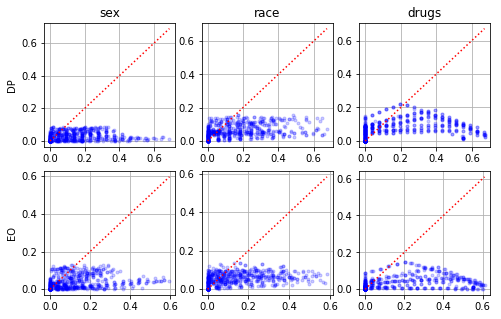

In [23]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp", "eo"]:
    data = pickle.load(open("./data/volf-fair-compas-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "race", "drugs"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        volf = [[], [], []]
        for i in range(len(data[Xs])):
            for j in range(3):
                volf[j] += list(data[Xs][i][j])
        plt.plot(volf[0], volf[1], ".", color="blue", alpha=0.2)
        print (np.mean(np.array(volf[0]) > np.array(volf[1])))
        plt.plot([0, np.max(volf[0])], [0, np.max(volf[0])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-adult.pdf", bbox_inches="tight")

0.775
0.9016666666666666
0.7833333333333333
0.8383333333333334
0.87
0.6666666666666666


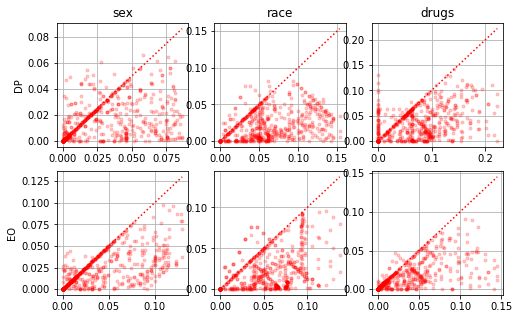

In [13]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp", "eo"]:
    data = pickle.load(open("./data/volf-fair-compas-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "race", "drugs"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        volf = [[], [], []]
        for i in range(len(data[Xs])):
            for j in range(3):
                volf[j] += list(data[Xs][i][j])
        plt.plot(volf[1], volf[2], ".", color="red", alpha=0.2)
        print (np.mean(np.array(volf[1]) > np.array(volf[2])))
        plt.plot([0, np.max(volf[1])], [0, np.max(volf[1])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-adult.pdf", bbox_inches="tight")

## $PoLF_1$ vs $PoLF_2$ for German dataset

600 0.9366666666666666
600 0.8816666666666667
600 0.9133333333333333
600 0.8466666666666667
600 0.875
600 0.7716666666666666


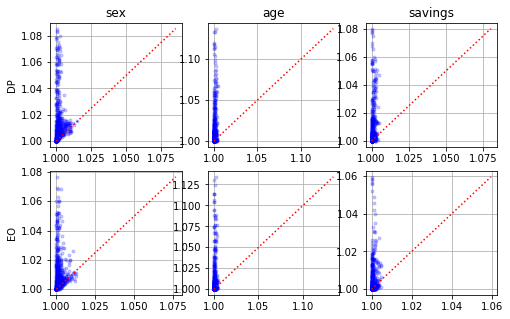

In [29]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp", "eo"]:
    data = pickle.load(open("./data/result-fair-german-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "age", "savings"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        polf = [[], [], []]
        for i in range(len(data[Xs])):
            for j in range(3):
                polf[j] += list(data[Xs][i][j])
        print (len(polf[0]), np.mean(np.array(polf[0]) < np.array(polf[1])))

        plt.plot(polf[0], polf[1], ".", color="blue", alpha=0.2)
        plt.plot([1, np.max(polf[1])], [1, np.max(polf[1])], color="red", linestyle=":")
        plt.grid()
        s += 1
plt.savefig("../ijcai19/fig/polf1-polf2-german.pdf", bbox_inches="tight")

# $VoLF_1$ vs $VoLF_2$ for German dataset

0.7066666666666667
0.64
0.7716666666666666
0.695
0.68
0.7616666666666667


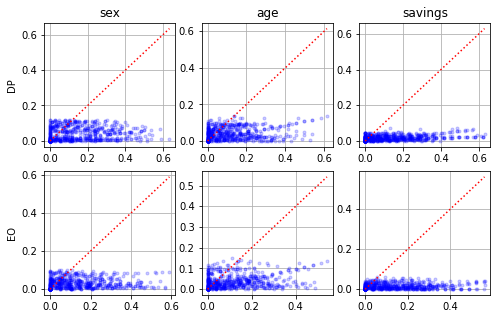

In [30]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp", "eo"]:
    data = pickle.load(open("./data/volf-fair-german-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "age", "savings"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        volf = [[], [], []]
        for i in range(len(data[Xs])):
            for j in range(3):
                volf[j] += list(data[Xs][i][j])
        plt.plot(volf[0], volf[1], ".", color="blue", alpha=0.2)
        print (np.mean(np.array(volf[0]) > np.array(volf[1])))
        plt.plot([0, np.max(volf[0])], [0, np.max(volf[0])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-adult.pdf", bbox_inches="tight")

0.6316666666666667
0.5783333333333334
0.605
0.6583333333333333
0.595
0.6016666666666667


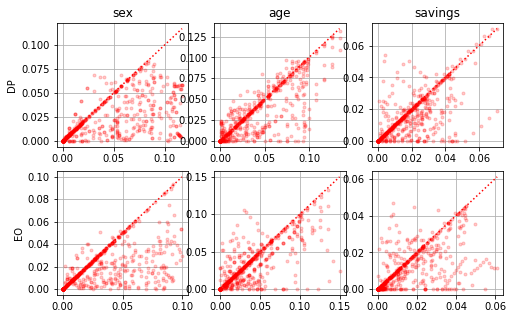

In [16]:
plt.figure(figsize=(8, 5))
s=1
for fairness_def in ["dp", "eo"]:
    data = pickle.load(open("./data/volf-fair-german-{}.pickle".format(fairness_def), "rb"))
    for Xs in ["sex", "age", "savings"]:
        plt.subplot(2,3,s)
        if s < 4:
            plt.title(Xs)
        if s == 1:
            plt.ylabel("DP")
        elif s == 4:
            plt.ylabel("EO")
        volf = [[], [], []]
        for i in range(len(data[Xs])):
            for j in range(3):
                volf[j] += list(data[Xs][i][j])
        plt.plot(volf[1], volf[2], ".", color="red", alpha=0.2)
        print (np.mean(np.array(volf[1]) > np.array(volf[2])))
        plt.plot([0, np.max(volf[1])], [0, np.max(volf[1])], color="red", linestyle=":")
        plt.grid()
        s += 1
# plt.savefig("../ijcai19/fig/polf1-polf2-adult.pdf", bbox_inches="tight")